In [1]:
import numpy as np
from PIL import Image
import os
import string
from pickle import dump
from pickle import load
from keras.applications.xception import Xception #to get pre-trained model Xception
from keras.applications.xception import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.text import Tokenizer #for text tokenization
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import concatenate
from keras.models import Model, load_model
from keras.layers import Input, Dense#Keras to build our CNN and LSTM
from keras.layers import LSTM, Embedding, Dropout
from tqdm import tqdm_notebook as tqdm #to check loop progress
tqdm().pandas()

C:\Users\Utkarsha\AppData\Local\Temp\ipykernel_3564\3914123727.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


0it [00:00, ?it/s]

# Perform Data Cleaning

In [4]:
# Load the document file into memory
def load_fp(filename):
    # Open file to read
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [5]:
# get all images with their captions
def img_capt(filename):
    file = load_fp(filename)
    captions = file.split('\n')
#     print(captions)
    descriptions ={}
    for caption in captions[:-1]:
        li = caption.split('\t')
        img, caption = li[0],li[1]
        
        if img[:] not in descriptions:
            descriptions[img] = [ caption ]
            
        else:
            descriptions[img].append(caption)
    return descriptions
descriptions = img_capt('Flickr8k.token.txt')

In [6]:
#Data cleaning function will convert all upper case alphabets to lowercase, removing punctuations and words containing numbers
def txt_clean(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            descp = img_caption.split()
            #uppercase to lowercase
            descp = [wrd.lower() for wrd in descp]
            #remove punctuation from each token
            descp = [wrd.translate(table) for wrd in descp]
            #remove hanging 's and a
            descp = [wrd for wrd in descp if(len(wrd)>1)]
            #remove words containing numbers with them
            descp = [wrd for wrd in descp if(wrd.isalpha())]
            #converting back to string
            img_caption = ' '.join(descp)
            captions[img][i]= img_caption
    return captions

In [7]:
def txt_vocab(descriptions):
    # To build vocab of all unique words
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

len(txt_vocab(descriptions))

6480

In [8]:
#To save all descriptions in one file
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()
    # Set these path according to project folder in you system, like i create a folder with my name shikha inside D-drive
    dataset_text = r"C:\Users\Utkarsha\Project\txt"   # fliker8k_token.txt file present inside this
    dataset_images = r"C:\Users\Utkarsha\Project\images" # fliker8k_images present inside this 
    #to prepare our text data
    filename = dataset_text + "/Flickr8k.token.txt"   # combining directory and filename 
    #loading the file that contains all data
    #map them into descriptions dictionary 
    descriptions = img_capt(filename) # description file will be returned
    print("Length of descriptions =" ,len(descriptions))
                    #cleaning the descriptions
    clean_descriptions = txt_clean(descriptions)  # getting clean data from the txt_clean function declared above 
                    #to build vocabulary
    vocabulary = txt_vocab(clean_descriptions)  # getting unique words from the description as vocabulary
    print("Length of vocabulary = ", len(vocabulary))
#saving all descriptions in one file
save_descriptions(descriptions, "descriptions.txt")

Length of descriptions = 7527
Length of vocabulary =  6480


# FEATURE EXTRACTION 

In [432]:
from keras.preprocessing import image
from keras.applications.xception import Xception, preprocess_input
from tqdm import tqdm
import numpy as np
from PIL import Image
import os
from pickle import dump, load

def extract_features(directory):
    model = Xception(include_top=False, pooling='avg')   # pre-build model with pooling set as "avg"  and will take images in dimention of 299x299
    features = {}

    for pic in tqdm(os.listdir(directory)): 
        file_path = os.path.join(directory, pic)
        try:
            image = Image.open(file_path)
            image = image.resize((299, 299))
            image = np.expand_dims(image, axis=0)  # adding one more dimension to the image as batch size and will take one image at time  
            image = preprocess_input(image)  # used when using pre-trained model
            feature = model.predict(image)
            features[pic] = feature
        except Exception as e:
            print(f"Error processing image {file_path}: {e}")

    return features

directory = 'Flicker8k_Dataset'
features = extract_features(directory)
dump(features open("features.p", "wb"))
# To directly load the features from the pickle file.



In [2]:
features = load(open("features.p", "rb"))

In [11]:
i=0
train_data={}
test_data={}
valid_data={}
for key,value in features.items():
    i=i+1
    if i < 6001:
        train_data['key']=value
    if i>=6001 and i<=7001:
        test_data['key']=value
    if i>=7001:
        valid_data['key']=value
        
    

In [9]:
len(descriptions)

7527

In [12]:
def load_photos(filename):
    file = load_fp(filename)
    photos = file.split("\n")[:-1]
    return photos


In [13]:
def load_clean_descriptions(filename, photos):   
    #loading clean_descriptions
    file = load_fp(filename)
    descriptions = {}
    for line in file.split("\n"):   
        words = line.split()
        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]
        
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)

    return descriptions


In [14]:
def load_features(photos):
    #loading all features
    all_features = load(open("features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features

filename = "Flickr_8k.trainImages.txt"
#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)
print(len(train_descriptions))

5576


In [15]:
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    print(all_desc)
    return all_desc


In [16]:
#creating tokenizer class
#this will vectorise text corpus
#each integer will represent token in dictionary
from keras.preprocessing.text import Tokenizer
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
#     print(desc_list)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)  # fitting caption in tokenizer
    return tokenizer

In [32]:
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
#print(tokenizer.word_index)
vocab_size = len(tokenizer.word_index) + 1
vocab_size #The size of our vocabulary is 7577 words.

['<start> man in street racer armor be examine the tire of another racer motorbike <end>', '<start> two racer drive white bike down road <end>', '<start> two motorist be ride along on their vehicle that be oddly design and color <end>', '<start> two person be in small race car drive by green hill <end>', '<start> two person in race uniform in street car <end>', '<start> firefighter extinguish fire under the hood of car <end>', '<start> fireman spray water into the hood of small white car on jack <end>', '<start> fireman spray inside the open hood of small white car on jack <end>', '<start> fireman use firehose on car engine that be up on carjack <end>', '<start> firefighter use water to extinguish car that be on fire <end>', '<start> boy sand surf down hill <end>', '<start> man be attempt to surf down hill make of sand on sunny day <end>', '<start> man be slide down huge sand dune on sunny day <end>', '<start> man be surf down hill of sand <end>', '<start> young man in short and tshirt

5577

In [18]:
#calculate maximum length of descriptions to decide the model structure parameters.
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
max_length = max_length(descriptions)
max_length #Max_length of description is 32

['man in street racer armor be examine the tire of another racer motorbike', 'two racer drive white bike down road', 'two motorist be ride along on their vehicle that be oddly design and color', 'two person be in small race car drive by green hill', 'two person in race uniform in street car', 'firefighter extinguish fire under the hood of car', 'fireman spray water into the hood of small white car on jack', 'fireman spray inside the open hood of small white car on jack', 'fireman use firehose on car engine that be up on carjack', 'firefighter use water to extinguish car that be on fire', 'boy sand surf down hill', 'man be attempt to surf down hill make of sand on sunny day', 'man be slide down huge sand dune on sunny day', 'man be surf down hill of sand', 'young man in short and tshirt be snowboard under bright blue sky', 'kid play in blue tub full of water outside', 'on hot day three small kid sit in big container fill with water', 'little kid sit outdoors in small tub of water', 'thr

32

In [19]:
def create_sequences(tokenizer, max_length, desc_list, feature):
    x_1, x_2, y = list(), list(), list()
    # move through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # divide one sequence into various X,y pairs
        for i in range(1, len(seq)):
            # divide into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            x_1.append(feature)
            x_2.append(in_seq)
            y.append(out_seq)
    return np.array(x_1), np.array(x_2), np.array(y)

In [20]:
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            inp_image, inp_seq, op_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[inp_image, inp_seq], op_word]

In [21]:
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape

((58, 2048), (58, 32), (58, 5577))

In [99]:
from keras.utils import plot_model
from keras.layers import add
# define the captioning model
def define_model(vocab_size, max_length):
    # features from the CNN model compressed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # merge it [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [112]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)
model = define_model(vocab_size, max_length)
epochs = 30
steps = len(train_descriptions)
# creating a directory named models to save our models
os.mkdir("models")
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save("models/model_" + str(i) + ".h5")

Dataset:  5999
Descriptions: train= 5576
Photos: train= 5999
Vocabulary Size: 5577
Description Length:  32
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_30 (InputLayer)       [(None, 32)]                 0         []                            
                                                                                                  
 input_29 (InputLayer)       [(None, 2048)]               0         []                            
                                                                                                  
 embedding_9 (Embedding)     (None, 32, 256)              1427712   ['input_30[0][0]']            
                                                                                                  
 dropout_18 (Dropout)        (None, 2048)                 0         ['input_29[0][0]

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'models'

# Testing the Image Caption Generator model

In [12]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse

In [13]:
import argparse
from IPython.display import display, HTML

# Function to simulate argparse in Jupyter Notebook
def simulate_argparse(image_path):
    return {'image': image_path}

# Provide a sample image path for testing
sample_image_path = r"C:\Users\Utkarsha\Project\Flicker8k_Dataset\529101401_ab1f6b1206.jpg"
# Simulate argparse
args = simulate_argparse(sample_image_path)

# Access the image path using the argument key 'image'
img_path = args['image']

# Now, you can use img_path in your notebook
print(f"Image path provided: {img_path}")


Image path provided: C:\Users\Utkarsha\Project\Flicker8k_Dataset\529101401_ab1f6b1206.jpg


In [14]:
from keras.applications.xception import Xception, preprocess_input
def extract_features(filename, model):
        try:
            image = Image.open(filename)
            
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        #image = preprocessed_input(image)
        image = image - 1.0
        feature = model.predict(image)
        return feature


In [15]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [16]:
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        # Convert the current seed text to a sequence of word IDs
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Pad the sequence to match the expected input length
        sequence = pad_sequences([sequence], maxlen=max_length)
        # Predict the next word ID
        pred = model.predict([photo, sequence], verbose=0)
        pred = np.argmax(pred)
        # Convert the predicted word ID to an actual word
        word = word_for_id(pred, tokenizer)
        # Break if an issue occurs or if 'end' is predicted
        if word is None or word == 'end':
            break
        # Append the predicted word to the input text
        in_text += ' ' + word

    return in_text




1/1 [==============================] - 1s 858ms/step
start boy in black be jump into the water


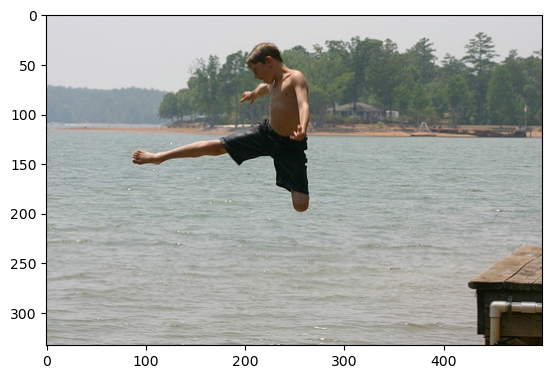

In [17]:
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('models/model_19.h5')
xception_model = Xception(include_top=False, pooling="avg")
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)
description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(img)
print(description)
